Epoch [1/250], Loss: 1.7427
Epoch [2/250], Loss: 1.5186
Epoch [3/250], Loss: 1.4960
Epoch [4/250], Loss: 1.4791
Epoch [5/250], Loss: 1.4757
Epoch [6/250], Loss: 1.4643
Epoch [7/250], Loss: 1.4690
Epoch [8/250], Loss: 1.4593
Epoch [9/250], Loss: 1.4498
Epoch [10/250], Loss: 1.4508
Epoch [11/250], Loss: 1.4458
Epoch [12/250], Loss: 1.4451
Epoch [13/250], Loss: 1.4465
Epoch [14/250], Loss: 1.4436
Epoch [15/250], Loss: 1.4420
Epoch [16/250], Loss: 1.4373
Epoch [17/250], Loss: 1.4322
Epoch [18/250], Loss: 1.4320
Epoch [19/250], Loss: 1.4328
Epoch [20/250], Loss: 1.4233
Epoch [21/250], Loss: 1.4169
Epoch [22/250], Loss: 1.4124
Epoch [23/250], Loss: 1.4031
Epoch [24/250], Loss: 1.3891
Epoch [25/250], Loss: 1.3827
Epoch [26/250], Loss: 1.3737
Epoch [27/250], Loss: 1.3643
Epoch [28/250], Loss: 1.3333
Epoch [29/250], Loss: 1.3046
Epoch [30/250], Loss: 1.2762
Epoch [31/250], Loss: 1.2453
Epoch [32/250], Loss: 1.1885
Epoch [33/250], Loss: 1.1520
Epoch [34/250], Loss: 1.1086
Epoch [35/250], Loss: 1

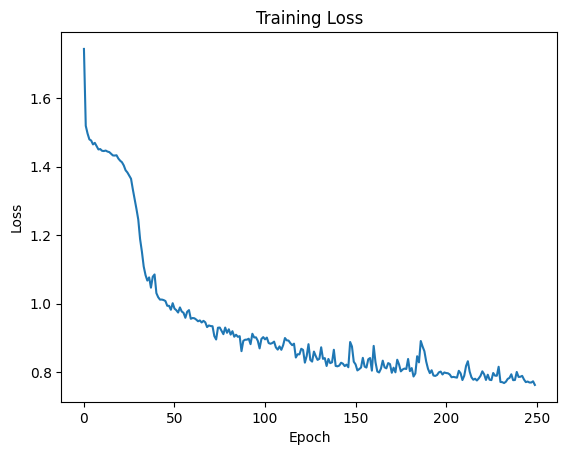

Accuracy on the test set: 66.32%


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

def load_triplets(file_path):
    with open(file_path, 'rb') as f:
        triplets = pickle.load(f)
    return triplets
import numpy as np

def preprocess_triplets(triplets):
    features_n1 = []
    features_n2 = []
    features_mutation = []
    consequence_n1 = []
    consequence_n2 = []
    consequence_mutation = []

    max_length = 0

    triplets = [triplet for triplet in triplets if len(triplet[0]) == len(triplet[1]) == len(triplet[2])]

    for triplet in triplets:
        n1, n2, mutation_of_interest = triplet
        # Remove normalized base pair location from the mutation of interest
        mutation_of_interest = mutation_of_interest.drop('Normalized Base Pair Position')
        n1 = n1.drop('Normalized Base Pair Position')
        n2 = n2.drop('Normalized Base Pair Position')

        n1Chrome = np.atleast_1d(n1['Chromosome'])
        n2Chrome = np.atleast_1d(n2['Chromosome'])
        muChrome = np.atleast_1d(mutation_of_interest['Chromosome'])

        # Extract binary-encoded features from n1, n2, and mutation of interest
        feature_n1 = np.concatenate([n1Chrome, n1['Mutation Encoded']])
        feature_n2 = np.concatenate([n2Chrome, n2['Mutation Encoded']])
        feature_mutation = np.concatenate([muChrome, mutation_of_interest['Mutation Encoded']])

        # Update maximum length if necessary
        max_length = max(max_length, len(feature_n1), len(feature_n2), len(feature_mutation))

        # Convert consequences to integers
        consequence_n1_int = int(n1['Consequence'])
        consequence_n2_int = int(n2['Consequence'])
        consequence_mutation_int = int(mutation_of_interest['Consequence'])

        # Store feature vectors for n1, n2, and mutation of interest
        features_n1.append(feature_n1)
        features_n2.append(feature_n2)
        features_mutation.append(feature_mutation)

        # Store the consequence values
        consequence_n1.append(consequence_n1_int)
        consequence_n2.append(consequence_n2_int)
        consequence_mutation.append(consequence_mutation_int)

    # Pad sequences with 2s to the maximum length
    features_n1 = pad_sequences(features_n1, maxlen=max_length, padding='post', value=2)
    features_n2 = pad_sequences(features_n2, maxlen=max_length, padding='post', value=2)
    features_mutation = pad_sequences(features_mutation, maxlen=max_length, padding='post', value=2)

    return features_n1, features_n2, features_mutation, consequence_n1, consequence_n2, consequence_mutation, max_length

class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMBlock, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        # Pass input through LSTM
        lstm_out, _ = self.lstm(x)

        return lstm_out

class FinalModel(nn.Module):
    def __init__(self, input_size_n1, input_size_n2, input_size_mutation, hidden_size, num_classes):
        super(FinalModel, self).__init__()
        self.lstm_n1 = LSTMBlock(input_size_n1, hidden_size)
        self.lstm_n2 = LSTMBlock(input_size_n2, hidden_size)
        self.lstm_mutation = LSTMBlock(input_size_mutation, hidden_size)
        self.fc = nn.Linear(hidden_size * 3, num_classes)

    def forward(self, x_n1, x_n2, x_mutation):
        lstm_out_n1 = self.lstm_n1(x_n1)
        lstm_out_n2 = self.lstm_n2(x_n2)
        lstm_out_mutation = self.lstm_mutation(x_mutation)

        # Concatenate the outputs
        combined_output = torch.cat((lstm_out_n1, lstm_out_n2, lstm_out_mutation), dim=1)

        # Apply fully connected layer
        output = self.fc(combined_output)

        return output

# Update training and testing functions to handle separate inputs for n1, n2, and mutation
def train_model(model, dataloader_n1, dataloader_n2, dataloader_mutation, criterion, optimizer, num_epochs=50):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs_n1, labels_n1), (inputs_n2, labels_n2), (inputs_mutation, labels_mutation) in zip(dataloader_n1, dataloader_n2, dataloader_mutation):
            inputs_n1, inputs_n2, inputs_mutation = inputs_n1.to(device), inputs_n2.to(device), inputs_mutation.to(device)
            labels_mutation = labels_mutation.to(device)

            optimizer.zero_grad()

            outputs = model(inputs_n1, inputs_n2, inputs_mutation)
            loss = criterion(outputs, labels_mutation)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        # Print the average loss for the epoch
        epoch_loss = running_loss / len(dataloader_n1)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

       # Plot loss history
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

def test_model(model, dataloader_n1, dataloader_n2, dataloader_mutation):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (inputs_n1, labels_n1), (inputs_n2, labels_n2), (inputs_mutation, labels_mutation) in zip(dataloader_n1, dataloader_n2, dataloader_mutation):
            inputs_n1, inputs_n2, inputs_mutation = inputs_n1.to(device), inputs_n2.to(device), inputs_mutation.to(device)
            labels_mutation = labels_mutation.to(device)

            # Forward pass
            outputs = model(inputs_n1, inputs_n2, inputs_mutation)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update total and correct predictions
            total += labels_mutation.size(0)
            correct += (predicted == labels_mutation).sum().item()

    # Print accuracy on the test set
    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    triplet_file_path = "/content/drive/MyDrive/DNA_Triplets/triplets.pkl"
    # Load triplets data
    triplets = load_triplets(triplet_file_path)

    # Preprocess triplets
    features_n1, features_n2, features_mutation, consequence_n1, consequence_n2, consequence_mutation, max_length = preprocess_triplets(triplets)
    batch_size=32

    # Prepare features and targets
    # Split data into training and testing sets
    features_n1_train, features_n1_test, consequence_mutation_train, consequence_mutation_test = train_test_split(features_n1, consequence_mutation, test_size=0.2, random_state=42)
    features_n2_train, features_n2_test, _, _ = train_test_split(features_n2, consequence_mutation, test_size=0.2, random_state=42)
    features_mutation_train, features_mutation_test, _, _ = train_test_split(features_mutation, consequence_mutation, test_size=0.2, random_state=42)

# Prepare features and targets for training
    features_n1_train_tensor = torch.tensor(features_n1_train, dtype=torch.float32)
    features_n2_train_tensor = torch.tensor(features_n2_train, dtype=torch.float32)
    features_mutation_train_tensor = torch.tensor(features_mutation_train, dtype=torch.float32)
    consequence_mutation_train_tensor = torch.tensor(consequence_mutation_train, dtype=torch.long)

# Create datasets and data loaders for training
    dataset_n1_train = TensorDataset(features_n1_train_tensor, consequence_mutation_train_tensor)
    dataset_n2_train = TensorDataset(features_n2_train_tensor, consequence_mutation_train_tensor)
    dataset_mutation_train = TensorDataset(features_mutation_train_tensor, consequence_mutation_train_tensor)

    dataloader_n1_train = DataLoader(dataset_n1_train, batch_size=batch_size, shuffle=True)
    dataloader_n2_train = DataLoader(dataset_n2_train, batch_size=batch_size, shuffle=True)
    dataloader_mutation_train = DataLoader(dataset_mutation_train, batch_size=batch_size, shuffle=True)

# Prepare features and targets for testing
    features_n1_test_tensor = torch.tensor(features_n1_test, dtype=torch.float32)
    features_n2_test_tensor = torch.tensor(features_n2_test, dtype=torch.float32)
    features_mutation_test_tensor = torch.tensor(features_mutation_test, dtype=torch.float32)
    consequence_mutation_test_tensor = torch.tensor(consequence_mutation_test, dtype=torch.long)

# Create datasets and data loaders for testing
    dataset_n1_test = TensorDataset(features_n1_test_tensor, consequence_mutation_test_tensor)
    dataset_n2_test = TensorDataset(features_n2_test_tensor, consequence_mutation_test_tensor)
    dataset_mutation_test = TensorDataset(features_mutation_test_tensor, consequence_mutation_test_tensor)

    dataloader_n1_test = DataLoader(dataset_n1_test, batch_size=batch_size, shuffle=False)
    dataloader_n2_test = DataLoader(dataset_n2_test, batch_size=batch_size, shuffle=False)
    dataloader_mutation_test = DataLoader(dataset_mutation_test, batch_size=batch_size, shuffle=False)
          # Define model parameters
    input_size_n1 = features_n1_train_tensor.shape[1]
    input_size_n2 = features_n2_train_tensor.shape[1]
    input_size_mutation = features_mutation_train_tensor.shape[1]
    hidden_size = 128  # Change this as needed
    num_classes = 8  # Change this according to your number of classes

# Instantiate the model
    model = FinalModel(input_size_n1=input_size_n1, input_size_n2=input_size_n2, input_size_mutation=input_size_mutation, hidden_size=hidden_size, num_classes=num_classes)
    model.to(device)

# Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Train the model
    train_model(model, dataloader_n1_train, dataloader_n2_train, dataloader_mutation_train, criterion, optimizer, num_epochs=250)

# Test the model
    test_model(model, dataloader_n1_test, dataloader_n2_test, dataloader_mutation_test)